# Notebook for plotting the visualizations

In [6]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
import pickle
import os
import sys
root = os.path.realpath(os.path.join(os.getcwd(),os.pardir))

sys.path.append(root)
from src.common import *
from src.model import main


In [7]:
train_data_file = os.path.join(DATA_DIR, "Data_Train.xlsx")
train_data = pd.read_excel(train_data_file)
train_data['Destination'].value_counts()

# Merge Dehli and New Delhi
def newd(x):
    if x=='New Delhi':
        return 'Delhi'
    else:
        return x

train_data['Destination'] = train_data['Destination'].apply(newd)

# Make day and month columns as Datetime columns.
if "Date_of_Journey" in train_data.columns:
    train_data['Journey_day'] = pd.to_datetime(
        train_data['Date_of_Journey'], format='%d/%m/%Y').dt.day
    train_data['Journey_month'] = pd.to_datetime(
        train_data['Date_of_Journey'], format='%d/%m/%Y').dt.month
    train_data["Day_of_Week"]= pd.to_datetime(
        train_data['Date_of_Journey'], format='%d/%m/%Y').dt.day_of_week
    train_data["Day_of_Year"]= pd.to_datetime(
        train_data['Date_of_Journey'], format='%d/%m/%Y').dt.day_of_year
    
    train_data.drop('Date_of_Journey', inplace=True, axis=1)

train_data.head()

In [5]:
if "Dep_Time" in train_data.columns:

    train_data['Dep_hour'] = pd.to_datetime(train_data['Dep_Time']).dt.hour
    train_data['Dep_min'] = pd.to_datetime(train_data['Dep_Time']).dt.minute
    train_data.drop('Dep_Time',axis=1,inplace=True)
if "Arrival_Time" in train_data.columns:

    train_data['Arrival_hour'] = pd.to_datetime(train_data['Arrival_Time']).dt.hour
    train_data['Arrival_min'] = pd.to_datetime(train_data['Arrival_Time']).dt.minute
    train_data.drop('Arrival_Time',axis=1,inplace=True)

train_data.head()

C:\Users\fpenaherrera_vaca\AppData\Local\Temp\ipykernel_35332\3603389430.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train_data['Dep_hour'] = pd.to_datetime(train_data['Dep_Time']).dt.hour
C:\Users\fpenaherrera_vaca\AppData\Local\Temp\ipykernel_35332\3603389430.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train_data['Dep_min'] = pd.to_datetime(train_data['Dep_Time']).dt.minute
C:\Users\fpenaherrera_vaca\AppData\Local\Temp\ipykernel_35332\3603389430.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train_data['Arrival_hour'] = pd.to_datetime(train_data['Arri

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Day_of_Week,Day_of_Year,Dep_hour,Dep_min,Arrival_hour,Arrival_min
0,IndiGo,Banglore,Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,24,3,6,83,22,20,1,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,1,5,2,121,5,50,13,15
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,19h,2 stops,No info,13882,9,6,6,160,9,25,4,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,5h 25m,1 stop,No info,6218,12,5,6,132,18,5,23,30
4,IndiGo,Banglore,Delhi,BLR → NAG → DEL,4h 45m,1 stop,No info,13302,1,3,4,60,16,50,21,35


In [6]:
# Get information on duration
if "Duration" in train_data.columns:
    duration = list(train_data['Duration'])
    for i in range(len(duration)):
        if len(duration[i].split()) != 2:
            if 'h' in duration[i]:
                duration[i] = duration[i] + ' 0m'
            else:
                duration[i] = '0h ' + duration[i]

    duration_hour = []
    duration_min = []

    for i in duration:
        h,m = i.split()
        duration_hour.append(int(h[:-1]))
        duration_min.append(int(m[:-1]))

    train_data['Duration_hours'] = duration_hour
    train_data['Duration_mins'] = duration_min

    train_data.drop('Duration',axis=1,inplace=True)
train_data.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Day_of_Week,Day_of_Year,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins
0,IndiGo,Banglore,Delhi,BLR → DEL,non-stop,No info,3897,24,3,6,83,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,No info,7662,1,5,2,121,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2 stops,No info,13882,9,6,6,160,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1 stop,No info,6218,12,5,6,132,18,5,23,30,5,25
4,IndiGo,Banglore,Delhi,BLR → NAG → DEL,1 stop,No info,13302,1,3,4,60,16,50,21,35,4,45


c:\Users\fpenaherrera_vaca\Software\Anaconda3\envs\fpredict\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


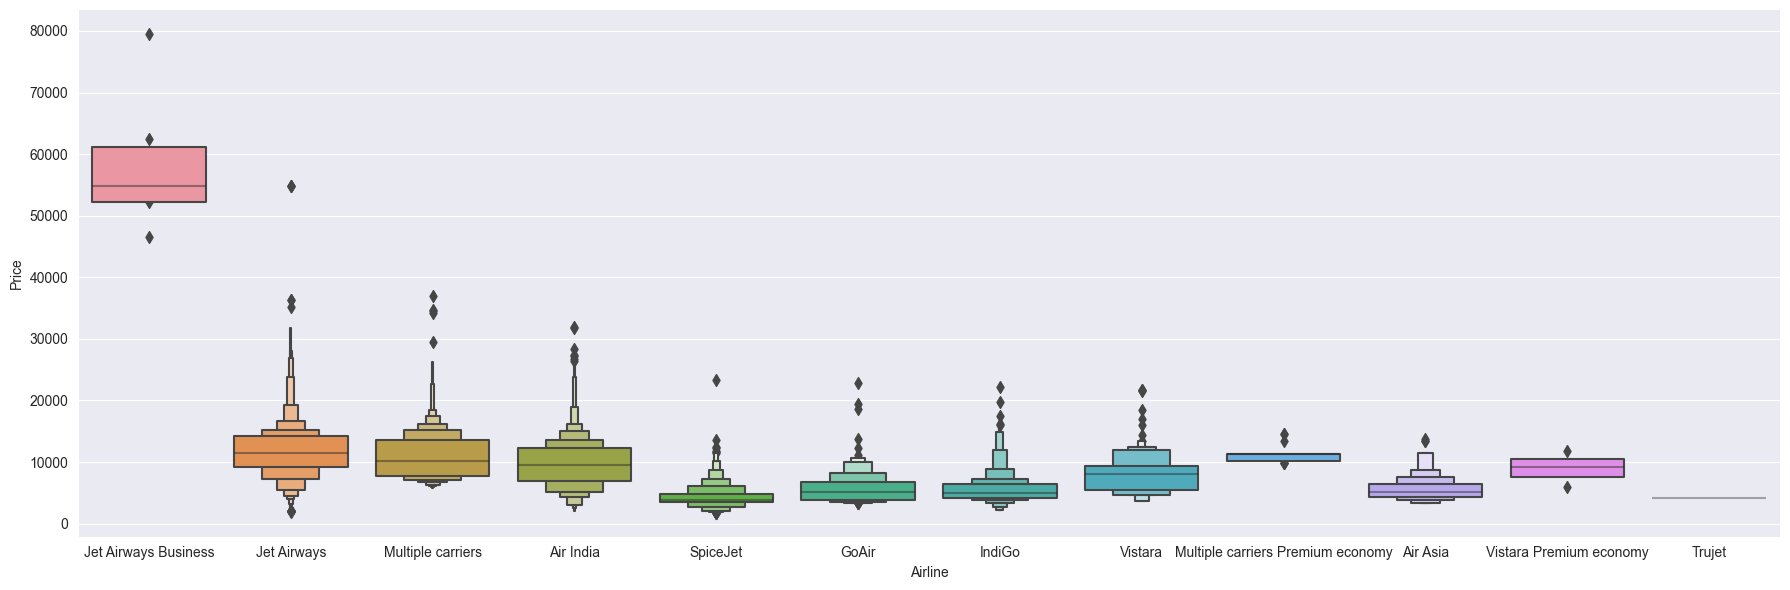

In [7]:
#Plot price information by price
sns.set_style("darkgrid")
sns.catplot(x='Airline',y='Price',data=train_data.sort_values('Price',ascending=False),kind='boxen',aspect=3,height=6)


In [8]:
# Create dummy columns out of the Airline column.
airline = train_data[['Airline']]
airline = pd.get_dummies(airline,drop_first=True)

c:\Users\fpenaherrera_vaca\Software\Anaconda3\envs\fpredict\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


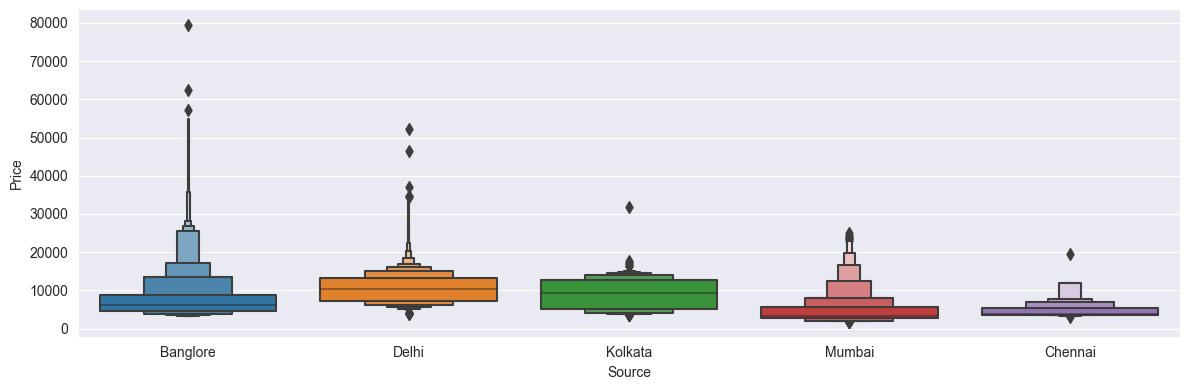

In [9]:
# Plotting Source vs Price.
# If we are going from Banglore the prices are slightly higher as compared to other cities
sns.catplot(x='Source',y='Price',data=train_data.sort_values('Price',ascending=False),kind='boxen',aspect=3,height=4)


In [10]:
source = train_data[['Source']]
source = pd.get_dummies(source,drop_first=True)
source.head()

,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai
0,False,False,False,False
1,False,False,True,False
2,False,True,False,False
3,False,False,True,False
4,False,False,False,False


c:\Users\fpenaherrera_vaca\Software\Anaconda3\envs\fpredict\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


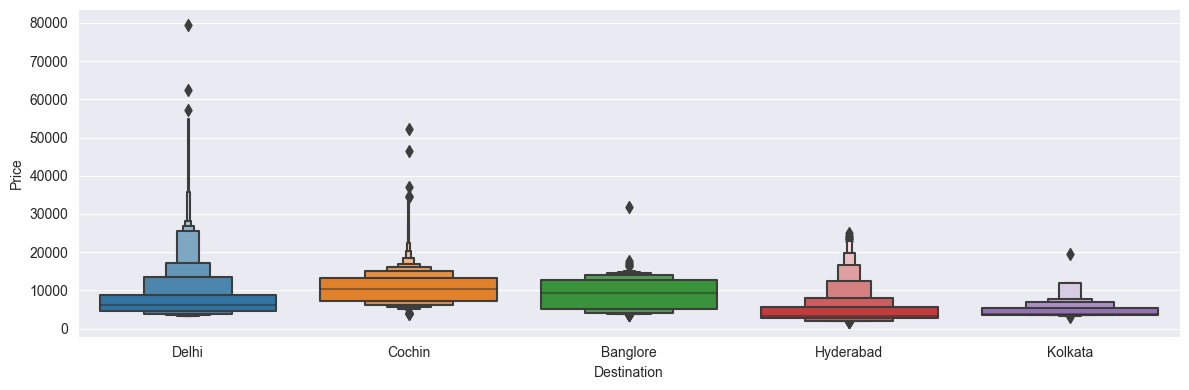

In [11]:
# Plotting Destination vs Price.
# If we are going to New Delhi the prices are slightly higher as compared to other cities
sns.catplot(x='Destination',y='Price',data=train_data.sort_values('Price',ascending=False),kind='boxen',aspect=3,height=4)


In [12]:
destination = train_data[['Destination']]
destination = pd.get_dummies(destination,drop_first=True)
destination.head()



,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata
0,False,True,False,False
1,False,False,False,False
2,True,False,False,False
3,False,False,False,False
4,False,True,False,False


In [13]:
if "Route" in train_data.columns and "Additional_Info" in train_data.columns:
    print("Doing")
    train_data.drop(['Route','Additional_Info'],inplace=True,axis=1)

Doing


In [14]:
# acc to the data, price is directly prop to the no. of stops
train_data['Total_Stops'].replace({'non-stop':0,'1 stop':1,'2 stops':2,'3 stops':3,'4 stops':4},inplace=True)
train_data.head()

,Airline,Source,Destination,Total_Stops,Price,Journey_day,Journey_month,Day_of_Week,Day_of_Year,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins
0,IndiGo,Banglore,Delhi,0.0,3897,24,3,6,83,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,2.0,7662,1,5,2,121,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,2.0,13882,9,6,6,160,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,1.0,6218,12,5,6,132,18,5,23,30,5,25
4,IndiGo,Banglore,Delhi,1.0,13302,1,3,4,60,16,50,21,35,4,45


In [15]:
data_train = pd.concat([train_data,airline,source,destination],axis=1)
data_train.dropna(inplace=True)
try:
    print("doing")
    data_train.drop(['Airline','Source','Destination'],axis=1,inplace=True)
except:
    pass
data_train.head()

doing


,Total_Stops,Price,Journey_day,Journey_month,Day_of_Week,Day_of_Year,Dep_hour,Dep_min,Arrival_hour,Arrival_min,...,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata
0,0.0,3897,24,3,6,83,22,20,1,10,...,False,False,False,False,False,False,False,True,False,False
1,2.0,7662,1,5,2,121,5,50,13,15,...,False,False,False,False,True,False,False,False,False,False
2,2.0,13882,9,6,6,160,9,25,4,25,...,False,False,False,True,False,False,True,False,False,False
3,1.0,6218,12,5,6,132,18,5,23,30,...,False,False,False,False,True,False,False,False,False,False
4,1.0,13302,1,3,4,60,16,50,21,35,...,False,False,False,False,False,False,False,True,False,False


In [16]:
# Taking out train data.
X = data_train.drop('Price',axis=1)
X.head()


,Total_Stops,Journey_day,Journey_month,Day_of_Week,Day_of_Year,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,...,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata
0,0.0,24,3,6,83,22,20,1,10,2,...,False,False,False,False,False,False,False,True,False,False
1,2.0,1,5,2,121,5,50,13,15,7,...,False,False,False,False,True,False,False,False,False,False
2,2.0,9,6,6,160,9,25,4,25,19,...,False,False,False,True,False,False,True,False,False,False
3,1.0,12,5,6,132,18,5,23,30,5,...,False,False,False,False,True,False,False,False,False,False
4,1.0,1,3,4,60,16,50,21,35,4,...,False,False,False,False,False,False,False,True,False,False


In [17]:
y = data_train['Price']
y.head()

0     3897
1     7662
2    13882
3     6218
4    13302
Name: Price, dtype: int64

In [18]:
train_data.head()

,Airline,Source,Destination,Total_Stops,Price,Journey_day,Journey_month,Day_of_Week,Day_of_Year,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins
0,IndiGo,Banglore,Delhi,0.0,3897,24,3,6,83,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,2.0,7662,1,5,2,121,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,2.0,13882,9,6,6,160,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,1.0,6218,12,5,6,132,18,5,23,30,5,25
4,IndiGo,Banglore,Delhi,1.0,13302,1,3,4,60,16,50,21,35,4,45


doing


<Axes: >

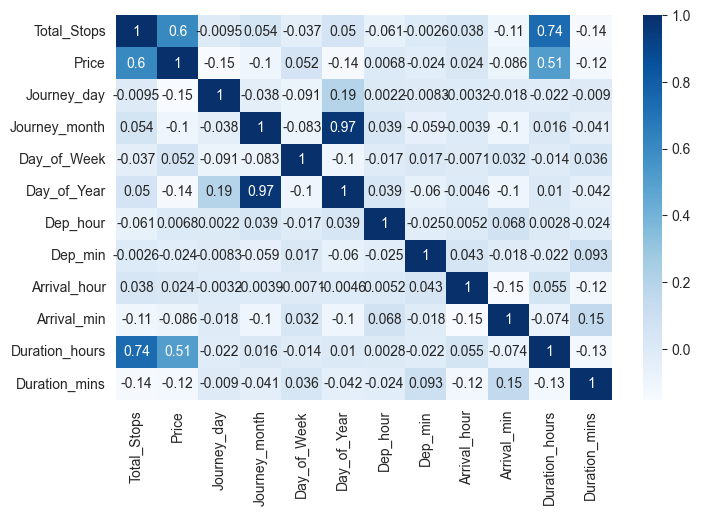

In [19]:
try:
    print("doing")
    train_data.drop(['Airline','Source','Destination'],axis=1,inplace=True)
except:
    pass

fig,ax= plt.subplots(figsize=(8,5))
sns.heatmap(train_data.corr(),cmap='Blues',annot=True, ax=ax)

In [20]:
reg = ExtraTreesRegressor()
reg.fit(X,y)


ExtraTreesRegressor()

In [21]:
print(reg.feature_importances_)
list_feat_import = [x for x in reg.feature_importances_]
list_feat_import=[round(x/min(list_feat_import)) for x in list_feat_import]

for x in range(len(X.columns)):
    print(list(X.columns)[x], list_feat_import[x])

[2.29844550e-01 5.38742514e-02 2.75786992e-02 1.72403995e-02
 1.09303964e-01 2.42372409e-02 2.07533074e-02 2.84491184e-02
 1.79662860e-02 1.28696766e-01 1.75126837e-02 9.18021490e-03
 1.83597621e-03 1.65595339e-02 1.40419062e-01 6.62236459e-02
 1.97311090e-02 9.55951746e-04 4.39730164e-03 1.00983509e-04
 4.74270578e-03 6.88060958e-05 8.33496178e-04 1.25535674e-02
 5.44068752e-03 6.81395793e-03 1.08682601e-02 1.40903470e-02
 8.74755606e-03 9.79570221e-04]
Total_Stops 3340
Journey_day 783
Journey_month 401
Day_of_Week 251
Day_of_Year 1589
Dep_hour 352
Dep_min 302
Arrival_hour 413
Arrival_min 261
Duration_hours 1870
Duration_mins 255
Airline_Air India 133
Airline_GoAir 27
Airline_IndiGo 241
Airline_Jet Airways 2041
Airline_Jet Airways Business 962
Airline_Multiple carriers 287
Airline_Multiple carriers Premium economy 14
Airline_SpiceJet 64
Airline_Trujet 1
Airline_Vistara 69
Airline_Vistara Premium economy 1
Source_Chennai 12
Source_Delhi 182
Source_Kolkata 79
Source_Mumbai 99
Destinatio

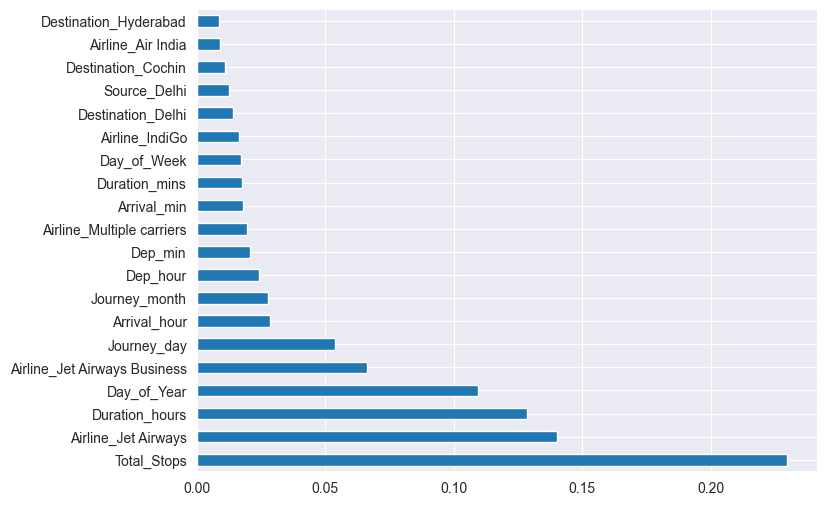

In [22]:
plt.figure(figsize = (8,6))
feat_importances = pd.Series(reg.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

In [23]:
# Here we are using RandomizedSearchCV which just randomly tries out combinations and sees which one is the best out of them.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
# Random search of parameters, using 5 fold cross validation, search across 100 different combinations
rf_random = RandomizedSearchCV(estimator = RandomForestRegressor(), param_distributions = random_grid,
                               scoring='neg_mean_squared_error', n_iter = 10, cv = 5, 
                               verbose=0, random_state=42, n_jobs = 1)
rf_random.fit(X_train,y_train)

c:\Users\fpenaherrera_vaca\Software\Anaconda3\envs\fpredict\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
20 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\fpenaherrera_vaca\Software\Anaconda3\envs\fpredict\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\fpenaherrera_vaca\Software\Anaconda3\envs\fpredict\lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "c:\Users\fpenaherrera_vaca\Software\Anaconda3\envs\fpredict\lib\site-pack

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   random_state=42, scoring='neg_mean_squared_error')

In [24]:
rf_random.best_params_


{'n_estimators': 300,
 'min_samples_split': 15,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 15}

C:\Users\fpenaherrera_vaca\AppData\Local\Temp\ipykernel_35332\3812498839.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test-prediction)


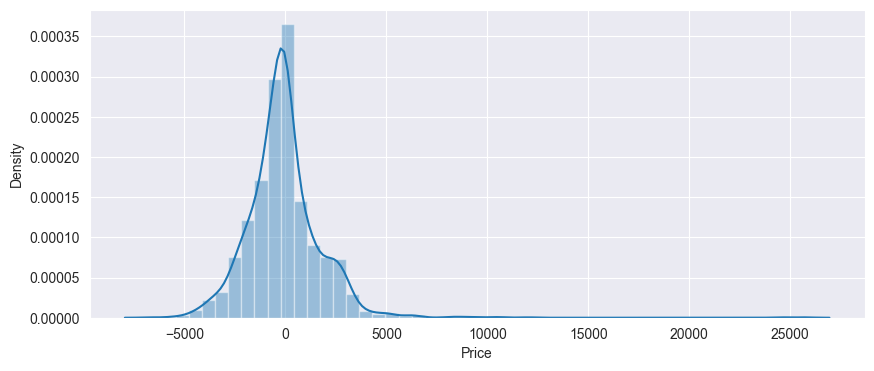

In [25]:
# Flight Price Prediction
prediction = rf_random.predict(X_test)
plt.figure(figsize = (10,4))
sns.distplot(y_test-prediction)
plt.show()

c:\Users\fpenaherrera_vaca\Software\Anaconda3\envs\fpredict\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


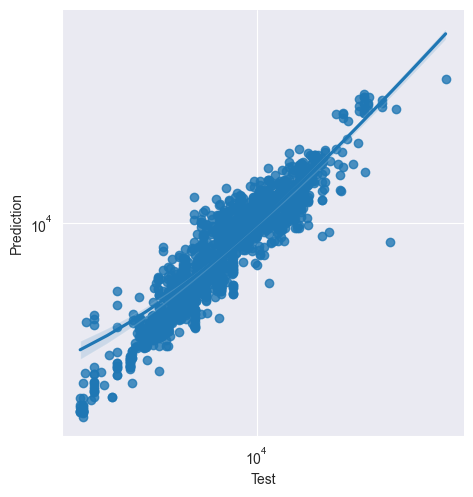

In [26]:
#fig,ax= plt.subplots(figsize = (8,4))
data = pd.DataFrame(columns=["Test", "Prediction"])
data["Test"]=y_test
data["Prediction"]=prediction
grid= sns.lmplot(data=data, x= "Test", y="Prediction")
sns.set_style("darkgrid")
ax = grid.axes[0][0]
ax.set_xscale('log')
ax.set_yscale('log')


In [27]:
file = open('flight_rf.pkl', 'wb')
pickle.dump(rf_random, file)

TypeError: regplot() got an unexpected keyword argument 'log'

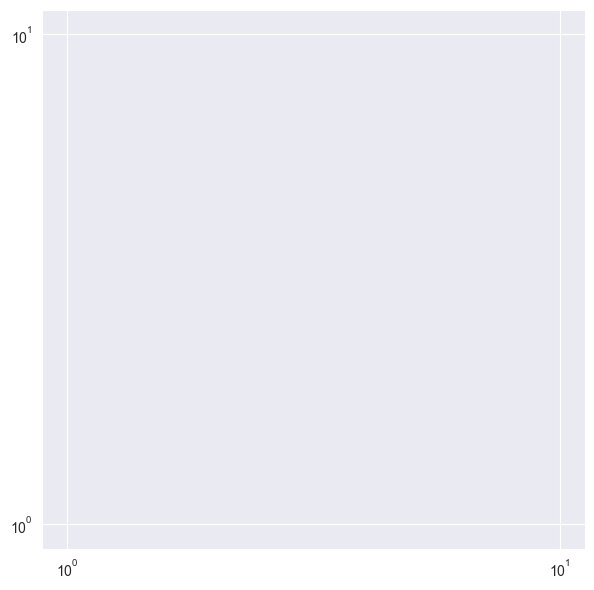

In [28]:

f, ax = plt.subplots(figsize=(7, 7))
ax.set(xscale="log", yscale="log")
sns.regplot(data=data, x="Test", y="Prediction", ax=ax, 
            log=True,
            scatter_kws={"s": 20, "color":"g", "alpha": 0.5, "edgecolor": None,
                                                                     "linewidths": 0.})

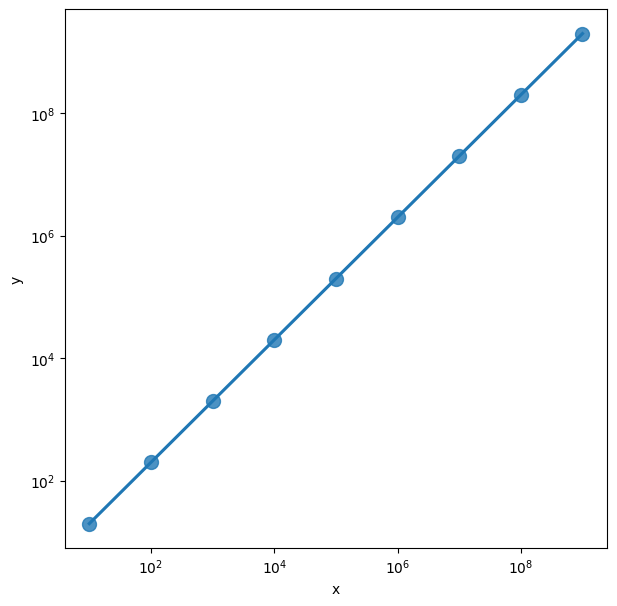

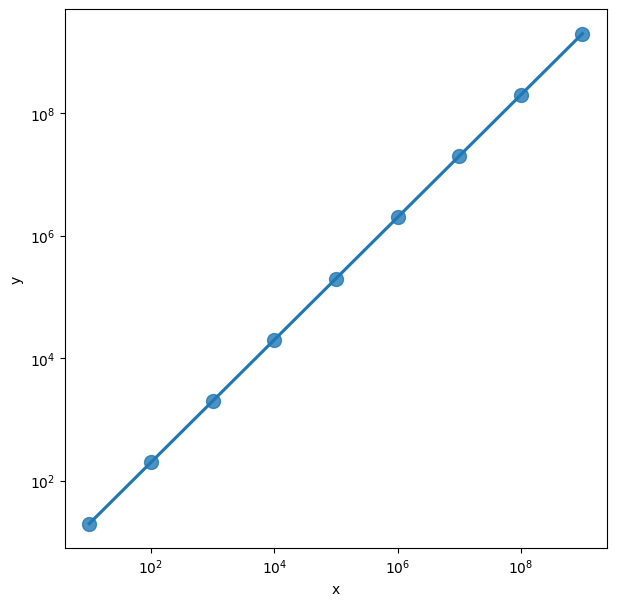

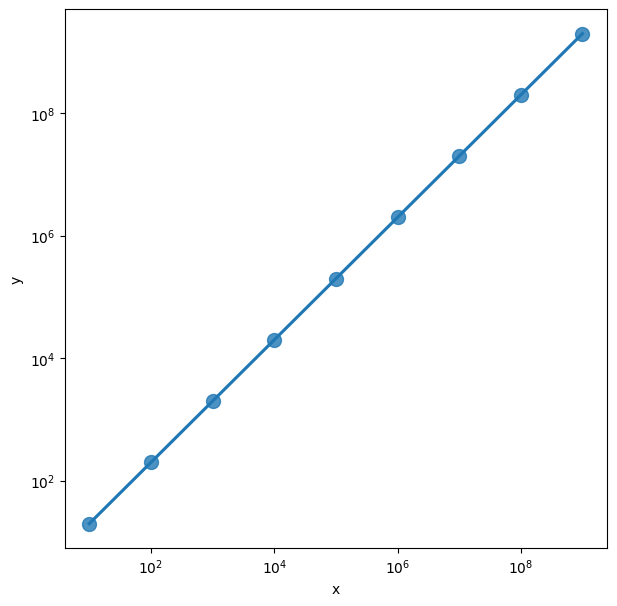

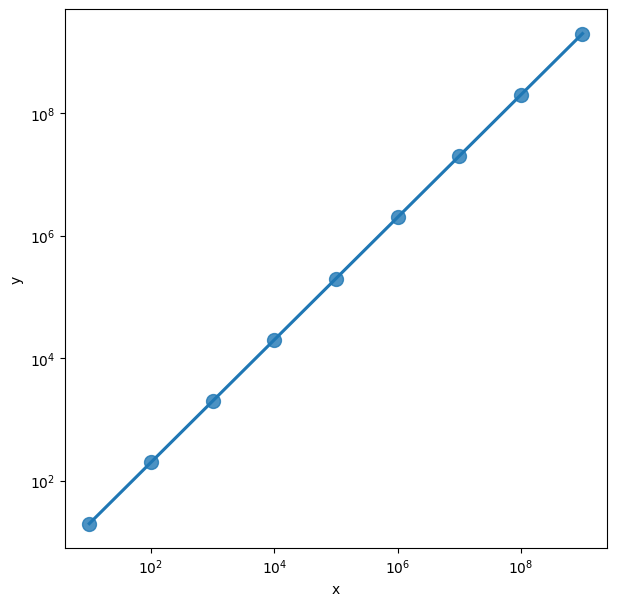

In [ ]:
x = 10 ** np.arange(1, 10)
y = x * 2
data2 = pd.DataFrame(data={'x': x, 'y': y})
f, ax = plt.subplots(figsize=(7, 7))
ax.set(xscale="log", yscale="log")
sns.regplot(x="x",y= "y",data= data2, ax=ax, scatter_kws={"s": 100})
plt.show()